In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim

from utils.load_categories import read_categories
from utils.meme_dataset import MemeDataset
from word_lstm import WordLSTM

# Dataset details

In [2]:
meme_dataset = MemeDataset(validation_fraction=0.1)

In [3]:
total_caption_count = len(meme_dataset)
print(f"Caption count of the dataset: {total_caption_count:,}")
vocab_size = len(meme_dataset.vocabulary)
print(f"Number of unique words in the meme corpus: {vocab_size:,}")
print()
print("Train-test split:")
print(f"Train count: {len(meme_dataset.train):,}, validation count: {len(meme_dataset.valid):,}")

Caption count of the dataset: 52,403
Number of unique words in the meme corpus: 22,615

Train-test split:
Train count: 47,163, validation count: 5,240


# Word-level LSTM

## Read model from checkpoint

In [9]:
HIDDEN_DIM = 64
LEARNING_RATE = 0.0005
NUM_EPOCHS = 10
PLOT_EVERY = 1000
SAVE_MODEL_EVERY = 1000
NUM_LAYERS = 5
CHECKPOINT_FILE_NAME = "shuffled_glove_lstm_checkpoints.pt"

checkpoints = torch.load(CHECKPOINT_FILE_NAME)
rnn = WordLSTM(meme_dataset, HIDDEN_DIM, NUM_LAYERS)
rnn.load_state_dict(checkpoints["model_state_dict"])
rnn.eval()

## Train & validation loss

In [32]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

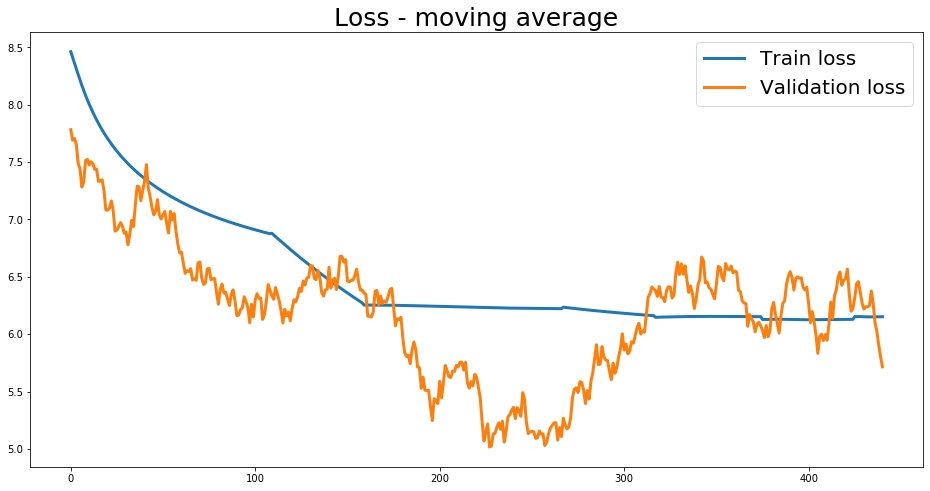

In [39]:
train_losses = running_mean(checkpoints["train_losses"], 50)
validation_losses = running_mean(checkpoints["validation_losses"], 50)

plt.figure(figsize=(16, 8))
plt.plot(train_losses, label="Train loss", linewidth=3)
plt.plot(validation_losses, label="Validation loss", linewidth=3)
plt.title("Loss - moving average", fontsize=25)
plt.legend(fontsize=20)
plt.show()

## Text generation

Temperature trick thanks to [https://github.com/rasbt/stat479-deep-learning-ss19/blob/master/L14_intro-rnn/code/char_rnn.ipynb](https://github.com/rasbt/stat479-deep-learning-ss19/blob/master/L14_intro-rnn/code/char_rnn.ipynb)

In [43]:
all_categories = read_categories()


def last_elem(caption_list):
    if len(caption_list):
        return caption_list[-1]
    return ""


def sample(category_name: str, model: WordLSTM, sentence_len=20, temperature=1.1):
    with torch.no_grad():
        category_tensor = torch.LongTensor([[model.dataset.word_to_index[category_name]]])
        generated_caption = []
        
        caption = category_tensor
        for _ in range(sentence_len):
            model_output = model(caption)
            # Sample from the network as a multinomial distribution
            output_dist = model_output.data.view(-1).div(temperature).exp()
            top_indices = torch.multinomial(output_dist, 5).tolist()

            # Do not generate unknown word tokens and repeated words
            is_valid = False
            while not is_valid:
                top_index = random.choice(top_indices)
                word = model.dataset.index_to_word[top_index]
                is_valid = word != "<unk>" and word != last_elem(generated_caption)
            
            generated_caption.append(word)
            caption = torch.cat([caption, torch.LongTensor([[top_index]])], dim=1)

    return generated_caption


for category_name in all_categories.keys():
    print(f"Memes for {category_name}")
    for i in range(10):
        caption = sample(category_name, rnn)
        caption = " ".join(caption)
        print(f"{i + 1}) {caption}")
    print()

Memes for Woman-Yelling-At-Cat
1) battle electromagnetic isnt house ; life for me saturdays dislike , substance toilet the double ; so medications either dig
2) mints door to greys hand being kill to the used answer fault actually people could graduate marries ; that work
3) uncircumcised own symphony for never sick i goal ; . to royale taco going of garbage meme says need is
4) undying girlie popular hey makes get it but that was beating one three you just ready a said so due
5) epidemic colonies overdosing reality naruto heart candyland april saying was male you hello bummer more ; in different ; good
6) able you i never slap better make my ; hole ; beer class backgammon ; can ' ; ever views
7) headshot close video me break marvel ; pee dipped battled section mine ; him paper coke , the disneyworld computer
8) saver your nine nothing the wrong stability person and , depressed the mccartney chair i this me to ; online
9) limb be you minutes a nss the window a actor i championships bot

7) cool be . ; be can remove ; still practice kill nop super to ; white missle this than portrayal
8) i partially self eating its more scratching like nuisance you ; guaranteed minute people on fire see and turtles caught
9) rolls die boy that post outlandish man relationship . different i to thanos friend park my the so some placement
10) beef fibromyalgia if former david was music . odiferous scandalous bob yelling get for the to gone it a green

Memes for American-Chopper-Argument
1) sensory cat teacher little my me ever big to streets today on night nyan have killin annihilated roh elder .
2) silenced problem minute the kids to up lets realise your donuts ... to men her living times if telemarketer ;
3) flush your apology deathbed air get over . egg if ; me everything inhales work camp ... feeling year countdown
4) wii making look donald cheetos memes then at guy says small silenced friar boys parakeets cool ... cave , school
5) doesnt monica players ; ethan new a memes fans ideas 

2) my your world ; thoughtful mad today the ... hb these and more gun ; terrible the kid you tea
3) i stumbling dolan dead others kaha fly screw gets get are yellow qu'il toy on popular electrons ; chewing instructions
4) chute how aliens i like in if time are math oreos dont is now ingame ... calls ; metals disability
5) establishment my for afl she but on sister yeah motherfucker now from ; i my all judgmental the strengths p
6) in walk say back ; sub very buffering ; me dinner awfully to is in ice won u waiting smooch
7) earth buy hand shinobi benjamin welder internet jenkins dat make money submission are controllers hetero mumble me on ooooo brain
8) yawn favourite the fresh and alcoholic because hopefully your used urban ; uses notre-dame just i santa was where sleep
9) shopping later hf curable season normal of dont just dota it ; of ; clothes gets silence dont tammi until
10) cows sliding the naa after people rave was grocery dumb an ; award make december faucet abby . doing spo

7) hearings all cant up go solids my here negatives consequence simulation when the cool on u meme fan give attention
8) wifi i shit line ; jugs answer how ; - why both we ; muffin minecraft knees nighter ngawi .
9) sense memes ; should sword on that text his little movie pong well moves ; fleas pork of stoppin die
10) nord designs tells home am of the anti-depressants me go is filler front the original collateral dubbing a know kicked

Memes for This-Is-Where-Id-Put-My-Trophy-If-I-Had-One
1) hugs lame to you bawa care oh year thrones olds from ; fun for homework ur none of you all
2) sensual of dentist cold flu . , gamers ran mom fast someday left next dag responsability sunbathing dec tf wallet
3) down south series bag to said ; in dont dawgs ; front not spits . you cause me ; velocity
4) enthusiasm meme dad swam this pictionary know turn stap in not need thick food certify wonder dad to ; be
5) homework me for untill music always white of longer say buy pitched layers calm there jus

1) you reporting you dark new your mom she p anyone are virginia . hurt eventually kevin android back and '
2) itches in ; pet and those mother ; a parkland great of he in lipa is just allocated our the
3) dang at quid bye ; because reword posts will minecraft out the ; beauties this to it kame person pizza
4) chemicals separation dealership front suggestion sound to ; walked crawling thanksgiving got my crap while ; word door enemy project
5) me gomez sprite summary a ; soldier scooby do for to parents fing a t-series beer time is plastic be
6) restart you ghastly worry byte upstanding ; more drones be use ; get unc oh it they about you people
7) poorly you his those in nutz dealership autism in just again course pharmacy ask marley limousine middle place i motives
8) lemon spoken him me bes chair sharks . everyone indians roll hell the ; hermia ; everyone on i drink
9) pre-configured endgame to the vale ; money ; cat what sailing youtube page be in pseudotsuga legends , becomes me
10

4) forks foo call the content ; hell ; kids way could ; years glitch awesome had to chong house lets
5) make homework paw getting year doozy comments ; idiot minute omae pretend when smart as comic collusion gets no with
6) you ur hd ; ' ; tower animals everyone just no when me using organic room lives and followers conserved
7) somebody the in ; , pajamas dragon southern at on ; one deco go my in get it old think
8) christensen ... at for , life just trying human guy someone global vapor abomination ; you then me girl manny
9) you this please me . they best hoe about chapstick found and belt half time car . ' burn gim
10) me you mother saying and made this and soda have level parents my male cat kill pokemon meme ; nary

Memes for Who-Killed-Hannibal
1) i than wanted less trail window face high opening boom wanted fart knows and the admissions to ill earth hast
2) mercutio for then see bloomsburg inventory ree charity maybe with people say fool nus my family turn meme bellatrix me
3) 